In [1]:
import control as ct
import numpy as np

## Dynamic system
For now the system described in [[1]](https://www.researchgate.net/publication/313953201_PENS-wheel_one-wheeled_self_balancing_vehicle_balancing_control_using_PID_controller) is used for modelling the ice-wheel.
<p><img src="https://www.researchgate.net/profile/Eko-Binugroho/publication/313953201/figure/fig1/AS:570207736872961@1512959526621/Modeling-based-on-an-inverted-pendulum-principle_W640.jpg" alt="Alt Text" title="Fig. 1. Modeling based on an inverted pendulum principle"></p>

### Parameters
> Different index letters:<br>
>- **r** instead of **m** for rider<br>
>- **t** instead of **bt** for total vehicle
>- **w** for  wheel
>- **c** for chassis
>- for other changes old name in paranthesis

#### Wheel / Motor
$m_{w}$ : Mass of the wheel<br>
$r_{w}$ : Wheel radius ($r_{bt}$)<br>
$x_{w}$ : Horizontal position of the wheel<br>
$J_{w}$ : Inertia moment of the wheel<br>
$\tau$ : Motor torque<br>

#### Chassis
$m_{c}$ : Mass of chassis<br>
$l_{c}$ : COG of chassis<br>

#### Rider
$m_{r}$ : Average rider's mass<br>
$x_{r}$ : Horizontal position of the rider’s body ($x_{bt}$)<br>
$y_{r}$ : Vertical position of rider’s body ($y_{bt}$)<br>
$J_{r}$ : Inertia moment of the rider<br>
$h_{r}$ : Average rider's height<br>
$l_{r}$ : COG of rider
$d_{r}$ : Width of rider from the side

#### Vehicle
$\alpha_{1}$ : Angle between wheel axis and vehicle<br>
$\alpha_{2}$ : Angle between vehicle and vertical axis<br>

$m_{t}$ : Total vehicle weight<br>
$l_{t}$ : Distance between the wheel axis to the center of mass of the vehicle<br>

$g$ : Earth's gravitational acceleration<br>

In [51]:
# ice-wheel
m_w = 7.2 # kg
r_w = 0.127 # m
J_w = 1/2*m_w*r_w**2

# chassis
m_batteries = 28*67e-3 + 0.2 # kg (cells + bms?)
m_mot_contr = 0.5 # kg
m_c = 3 + m_batteries + m_mot_contr # kg
l_c = 0.02 # m -> COG of chassis is assumed to be in the center
h_base = 0.1
w_base = 0.75

# rider
m_r = 70 # kg
h_r = 1.85 # m
d_r = 0.2 # m
l_r_ = h_r * 0.55 # approximation of COG of human
l_r = l_r_ + h_base/2 # COG of rider from axel

g = 9.81 # m/s^2

# total
m_t = m_w + m_c + m_r # kg
l_t = (l_r*m_r + l_c*m_c) / m_t # m
J_t = 1/12*m_r*(h_r**2+d_r**2) + 1/2*m_c*l_c**2 - J_w

print(f'Center of gravity distance from wheel axis: {l_t:.3f} m.')
print(f'Total inertial moment of vehicle: {J_t:.3f} kgm\u00b2.')

Center of gravity distance from wheel axis: 0.904 m.
Total inertial moment of vehicle: 20.141 kgm².


### Differential equations
In [[1]](https://www.researchgate.net/publication/313953201_PENS-wheel_one-wheeled_self_balancing_vehicle_balancing_control_using_PID_controller) a simplified lagrange equation is used which neglects any friction forces.

#### Langrange
$q_r$ : coordinate angle on robot

(1) $\frac{d}{dt}\left(\frac{dE}{d\dot{q_r}}\right)-\frac{dE}{dq_r}+\frac{dU}{dq_r}=\tau_r$

#### Kinetic energy of rider and wheel (translation & rotation)

(2) $E=\frac{1}{2}(m_{t}v^2+l^2_{t}\dot{\alpha^2_{2}}+m_{t}vl_{t} cos(\alpha_{2}\dot{\alpha_{2}}) + \frac{1}{2}J_t\dot{\alpha^2_2}+\frac{1}{2}m_wv^2+\frac{1}{2}J_w\frac{v^2}{r^2_w}$
#### Potential energy
(3) $U=m_tgl_tcos(\alpha_2)$
#### Linearized equations
With (2) and (3) in (1) and the assumption that only one equilibrium, where the vehicle stands balanced, exits ($\alpha_2=0$ ; $sin(\alpha_2)\approx0$, $cos(\alpha_2)\approx1$), equations (4) and (5) can be drived.<br>

(4) $\ddot{x}=\left[-\frac{(m_tl_t)^2g}{den}\right]\alpha_2+\left[-\frac{m_tl_t}{den}\right]\tau$

(5) $\ddot{\alpha}_2=\left[\frac{\left(m_t+m_w+\frac{J_w}{r^2_w}\right)m_tgl_t}{den}\right]\alpha_2+\left[\frac{m_t+m_w+\frac{J_w}{r^2_w}}{den}\right]\tau$

$den=\left(m_t+m_w+\frac{J_w}{r^2_w}\right)\left(m_tl^2_t+J_t\right)-\left(m_tl_t\right)^2$

### State space model
<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Typical_State_Space_model_with_feedback.svg/350px-Typical_State_Space_model_with_feedback.svg.png" alt="Alt Text" title="State space model with feedback"></p>
$x(t)$ : State vector,&emsp; $y(t)$ : Output vector<br>
$A$ : State matrix, &emsp;&emsp;$C$ : Output matrix<br>
$B$ : Input matrix,&emsp; &emsp;$D$ : Direct transmission matrix<br>
<br>

(6) $\dot{x}(t)=Ax(t)+Bu(t)$

(7) $y(t)=Cx(t)+Du(t)$

(8) $X = \left[x\quad\alpha_2\quad\dot{x}\quad\dot{\alpha}_2\right]^T$

(9) $A = \left[\begin{array}{cccc} 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1\\ 0 & -\frac{(m_tl_t)^2g}{den} & 0 & 0 \\ 0 & \frac{\left(m_t+m_w+\frac{J_w}{r^2_w}\right)m_tgl_t}{den} & 0 & 0 \\ \end{array}\right]$

(10) $B = \left[\begin{array}{c} 0\\ 0\\ -\frac{m_tl_t}{den}\\  \frac{m_t+m_w+\frac{J_w}{r^2_w}}{den}\\ \end{array}\right]$

(11) $C = \left[\begin{array}{cccc} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ \end{array}\right]$

(12) $D = \left[\begin{array}{c} 0 \\ 0\\ \end{array}\right]$

In [25]:
import matplotlib.pyplot as plt
import control.matlab as mat

def bode(sys, y=['y1', 'y2'], omega=np.logspace(0, 5, 100)):
    mag, phase, _ = sys.frequency_response(omega, squeeze=True)
    
    fig ,axs = plt.subplots(2, 1, figsize=(12, 8))
    
    if len(y) == 1:
        axs[0].plot(omega, mag)
        axs[1].plot(omega, phase/np.pi*180)
    else:
        for i, _ in enumerate(y):
            axs[0].plot(omega, mag[i])
            axs[1].plot(omega, phase[i]/np.pi*180)

    axs[0].legend(y)    
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_ylabel('$A$')
    axs[0].grid(True)

    axs[1].legend(y)
    axs[1].set_xscale('log')
    axs[1].set_ylabel('$\phi$ [°]')
    axs[1].set_xlabel('$\omega$ [rad/s]')
    axs[1].grid(True)
    
    fig.suptitle('Frequency response')
    fig.tight_layout()


In [26]:
# State space model
den = (m_t + m_w + J_w/r_w**2)*(m_t*l_t**2 + J_t) - (m_t*l_t)**2 ###??? Why add the m_w to m_t ??

# State matrix values
A_32 = -((m_t*l_t)**2*g)/den
A_42 = (m_t + m_w + J_w/r_w**2)*m_t*g*l_t/den
A = [[0, 0, 1, 0],
     [0, 0, 0, 1],
     [0, A_32, 0, 0],
     [0, A_42, 0, 0]]


# Input matrix
B_3 = -m_t*l_t/den
B_4 = (m_t + m_w + J_w/r_w**2)/den
B = [[0], [0], [B_3], [B_4]]

# Output matrix
C = [[1, 0, 0, 0],
     [0, 1, 0, 0]]

# Direct transmission matrix
D = [[0], [0]]

H = ct.StateSpace(A, B, C, D)
display(H)

StateSpace(array([[ 0.       ,  0.       ,  1.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  1.       ],
       [ 0.       , -7.9477449,  0.       ,  0.       ],
       [ 0.       , 10.9762652,  0.       ,  0.       ]]), array([[ 0.        ],
       [ 0.        ],
       [-0.03252472],
       [ 0.04491839]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]]), array([[0.],
       [0.]]))

In [27]:
det = np.linalg.det(mat.ctrb(A, B))
if det == 0:
    print('Not controllable!')
else:
    print('Ok')

Not controllable!


In [28]:
# transfer funcs
G = mat.ss2tf(H)

# to separate transfer functions
G_x = G.returnScipySignalLTI()[0][0]
G_x = ct.TransferFunction(G_x.num, G_x.den)

G_alpha_2 = G.returnScipySignalLTI()[1][0]
G_alpha_2 = ct.TransferFunction(G_alpha_2.num, G_alpha_2.den)

ControlMIMONotImplemented: Not implemented for MIMO systems without slycot.

In [ ]:
bode(H, y=['x', r'$\alpha_2$'])

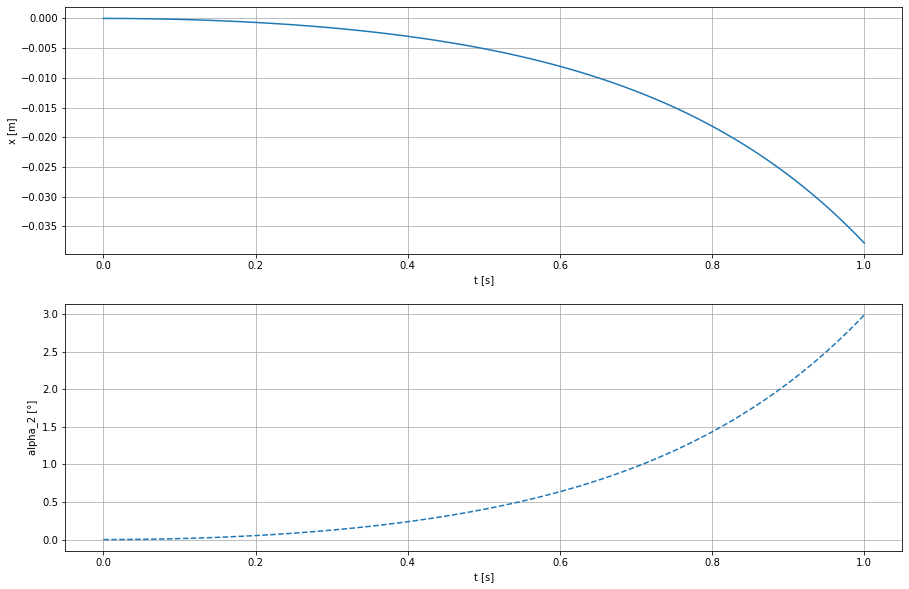

In [29]:
t = np.linspace(0, 1, 100)
y, t = mat.step(H, T=t, input=0, X0=[0, 0, 0, 0])

fig ,axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].plot(t,y.T[0, 0],'-')
axs[0].set_ylabel('x [m]')
axs[0].set_xlabel('t [s]')
axs[0].grid(True)


axs[1].plot(t,y.T[0, 1]*180/np.pi,'--')
axs[1].set_ylabel('alpha_2 [°]')
axs[1].set_xlabel('t [s]')
axs[1].grid(True)

## Motor

## PID Controller
In the paper they simply use a PID controller to control the wheel.

PID settings: $K_p=90$, $K_i=8$, $K_d=6$

In [ ]:
from control import TransferFunction

# PID settings from paper 
K_r = 90 # (K_p)
T_0 = 1/8 # (1/K_i)
T_d = 6 # (k_d)

# T_n = K_p / K_i
# T_v = K_d / K_p

K_r = 1 # (K_p)
T_0 = 1/8 # (1/K_i)
T_d = 1

s = TransferFunction.s
G_pid  = K_r + 1/(s*T_0) + T_d*s#/(1+0.1*T_d*s)
G_pid

In [ ]:
# K_d = T_d
# w_d = 1/(0.1*T_d)
# K_i = 1/T_0
# K_p = K_r

# w_d = 0.1*K_d
# A = [[0, 0],
#      [0, -w_d]]
# B = [[1], [w_d]]
# C = [K_i, K_d]
# D = w_d*K_d + K_p

# H_pid = ct.StateSpace(A, B, C, D)

# PID and System

In [ ]:
G_pid_x = G_pid*G_x
G_pid_alpha_2 = G_pid*G_alpha_2

bode(G_pid_x, y=['x',])
bode(G_pid_alpha_2, y=[r'$\alpha_2$'])

### Feedback

In [ ]:
# G_pid_x_feedback = G_pid_x.feedback()
G_pid_alpha_2_feedback = G_pid_alpha_2.feedback()

# bode(G_pid_x_feedback, y=['x',])
bode(G_pid_alpha_2_feedback, y=[r'$\alpha_2$'])

In [52]:
import matplotlib.pyplot as plt
import dataclasses


def draw_world(
    fig = None,
    ax = None,
    x_lim: list = [-2, 2],
    y_lim: list = [-0.5, 3],
    figsize: tuple = (15, 15),
    **kwargs
):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=figsize, **kwargs)
    ax.hlines(0, *x_lim ,'k')
    ax.vlines(0, *y_lim, linestyles='dashed', colors='k')
    ax.plot(0, 0)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal')
    ax.grid(True)
    return fig, ax



class IceWheel:
    _r_wheel: float
    _r_base: float
    _w_base: float
    _h_base: float
    _cog_rider: np.ndarray
    _h_rider: float
    
    _wheel_color: str = 'green'
    _base_color: str = 'blue'
    _rider_color: str = 'red'
    _rider_cog_r: float = 0.05
    
    _ax = None
    
    def __init__(
        self,
        r_wheel: float,
        r_base: float,
        w_base: float,
        h_base: float,
        cog_rider: np.ndarray,
        h_rider: float,
        ax = None
    ) -> None:
        self._r_wheel = r_wheel
        self._r_base = r_base
        self._w_base = w_base
        self._h_base = h_base
        self._cog_rider = cog_rider
        self._h_rider = h_rider
        self._ax = ax
        
    def set_ax(self, ax) -> None:
        self._ax = ax
    
    def get_ax(self, ax):
        return self._ax
        
    def draw(self, x: float, alpha_2: float, y: float = 0) -> None:
        alpha_transform = np.array([
            [np.cos(-alpha_2), -np.sin(-alpha_2)],
            [np.sin(-alpha_2), np.cos(-alpha_2)]
        ])

        # wheel
        xy_wheel = np.array([x, y+self._r_wheel])
        wheel = plt.Circle(xy_wheel, radius=self._r_wheel, color=self._wheel_color)
        self._ax.add_patch(wheel)
        self._ax.plot(*xy_wheel, 'r+', markersize=20)

        # chassis
        xy_base = xy_wheel + np.matmul(alpha_transform, np.array([-self._w_base/2, -self._r_base/2]))
        base = plt.Rectangle(xy_base, self._w_base, self._h_base, angle=-alpha_2*180/np.pi, color=self._base_color)
        self._ax.add_patch(base)

        # rider
        xy_rider_cog = xy_wheel + np.matmul(alpha_transform, self._cog_rider)
        xy_rider_head = xy_wheel + np.matmul(alpha_transform, [0, self._h_rider])

        rider_cog = plt.Circle(xy_rider_cog, radius=self._rider_cog_r, color=self._rider_color)
        plt.gca().add_patch(rider_cog)
        self._ax.plot([xy_wheel[0], xy_rider_head[0]], [xy_wheel[1], xy_rider_head[1]], '--', color=self._rider_color)
    
    def draw_multiple(self, X: np.ndarray, y: float = 0):
        for x, alpha_2 in X:
            self.draw(x, alpha_2, y)

ice_wheel_settings = dict(
    r_wheel=r_w,
    r_base=l_c,
    w_base=w_base,
    h_base=h_base,
    cog_rider=np.array([0, l_r]), # from axel
    h_rider=h_r
)

## Simulation
### System

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


t_end = 2 # s
t_per_second = 30
slow_mo = 1
n = int(t_end*t_per_second)

t = np.linspace(0, t_end, n)
y, t = mat.step(H, T=t, input=0, X0=[0, 0, 0, 0])

world_settings = dict(
    x_lim=[np.round(y.squeeze().T[0].min())-2, np.round(y.squeeze().T[0].max())+2]
)
    
fig, ax = draw_world(**world_settings)
wheel = IceWheel(**ice_wheel_settings)
wheel.set_ax(ax)

def animate(i):
    ax.clear()
    draw_world(fig, ax, **world_settings)
    wheel.draw(*y.squeeze()[i])

    
ani = FuncAnimation(fig, animate, frames=n , interval=slow_mo*1000/t_per_second, repeat=True)

HTML(ani.to_html5_video())



### PID and System

In [ ]:
t_end = 2 # s
t_per_second = 30
slow_mo = 1
n = int(t_end*t_per_second)

t = np.linspace(0, t_end, n)
y_x, t = mat.step(G_pid_x, T=t, input=0)#, X0=[0, 0, 0, 0])
y_alpha_2, t = mat.step(G_pid_alpha_2, T=t, input=0)#, X0=[0, 0, 0, 0])


world_settings = dict(
    x_lim=[np.round(y.squeeze().T[0].min())-2, np.round(y.squeeze().T[0].max())+2]
)
    
fig, ax = draw_world(**world_settings)
wheel = IceWheel(**ice_wheel_settings)
wheel.set_ax(ax)

def animate(i):
    ax.clear()
    draw_world(fig, ax, **world_settings)
    wheel.draw(y_x[i], y_alpha_2[i])

    
ani = FuncAnimation(fig, animate, frames=n , interval=slow_mo*1000/t_per_second, repeat=True)

HTML(ani.to_html5_video())

### PID and System Feedback

x not possible to compute, since it had to be reduced to SISO.

In [ ]:
t_end = 2 # s
t_per_second = 30
slow_mo = 1
n = int(t_end*t_per_second)

t = np.linspace(0, t_end, n)
# y_x, t = mat.step(G_pid_x, T=t, input=0, X0=[0, 0, 0, 0])
y_alpha_2, t = mat.step(G_pid_alpha_2_feedback, T=t, input=0)#, X0=[0, 0, 0, 0])


world_settings = dict(
    x_lim=[np.round(y.squeeze().T[0].min())-2, np.round(y.squeeze().T[0].max())+2]
)
    
fig, ax = draw_world(**world_settings)
wheel = IceWheel(**ice_wheel_settings)
wheel.set_ax(ax)

def animate(i):
    ax.clear()
    draw_world(fig, ax, **world_settings)
    wheel.draw(x=0, alpha_2=y_alpha_2[i])

    
ani = FuncAnimation(fig, animate, frames=n , interval=slow_mo*1000/t_per_second, repeat=True)

HTML(ani.to_html5_video())

### From file

In [48]:
from mat73 import loadmat

In [49]:
x = loadmat('../Matlab/Simulation_x.mat')
alpha = loadmat('../Matlab/Simulation_alpha.mat')
t = x['x'][0]

x = x['x'][1]
alpha = alpha['alpha'][1]

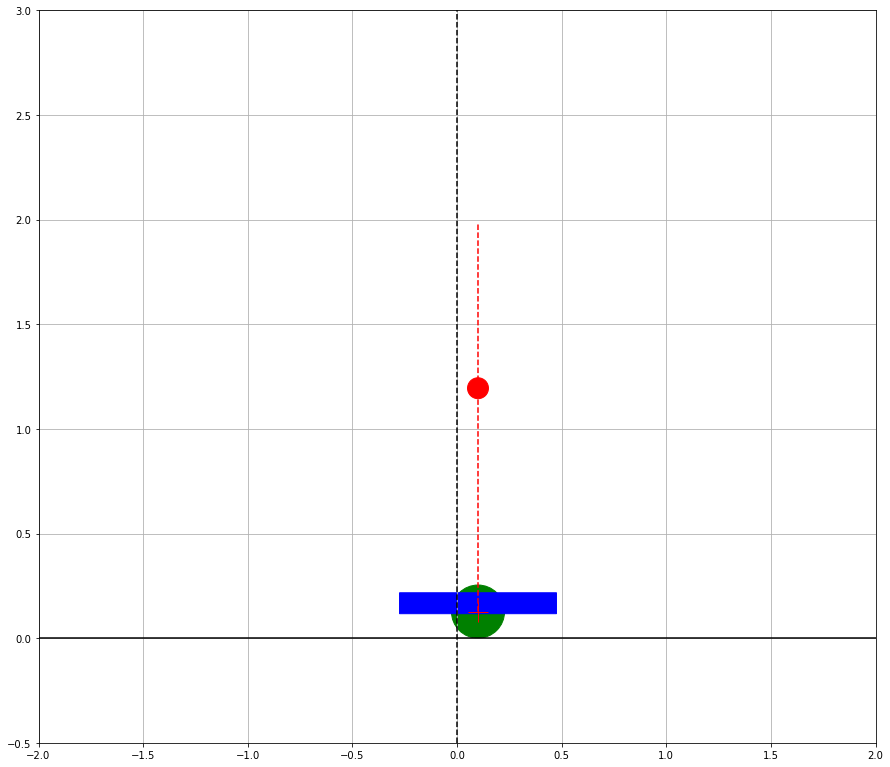

In [53]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


t_end = t.max() # s
t_per_second = int(len(t)/t.max())
slow_mo = 1
n = int(t_end*t_per_second)


# y, t = mat.step(H, T=t, input=0, X0=[0, 0, 0, 0])

world_settings = dict(
    x_lim=[np.round(y.squeeze().T[0].min())-2, np.round(y.squeeze().T[0].max())+2]
)
    
fig, ax = draw_world(**world_settings)
wheel = IceWheel(**ice_wheel_settings)
wheel.set_ax(ax)

def animate(i):
    ax.clear()
    draw_world(fig, ax, **world_settings)
    wheel.draw(x[i], alpha[i])

    
ani = FuncAnimation(fig, animate, frames=n , interval=slow_mo*1000/t_per_second, repeat=True)

HTML(ani.to_html5_video())
